In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
class LazyLoadDataset(Dataset):
    def __init__(self, path, train=0, transform=None):
        self.transform = transform
        self.train = train

        if self.train == 0:
            self.pathX = path + "train/"
        elif self.train == 1:
            self.pathX = path + "test/"
        else:
            self.pathX = path + "val/"

        self.pathY = "/content/drive/MyDrive/Project/small_processed_data/image_data.csv"

        self.img_data = pd.read_csv('/content/drive/MyDrive/Project/small_processed_data/image_data.csv')
        self.train_idx = self.img_data.index[self.img_data['folder'] == 'train'].tolist()
        self.test_idx = self.img_data.index[self.img_data['folder'] == 'test'].tolist()
        self.val_idx = self.img_data.index[self.img_data['folder'] == 'val'].tolist()
        
    def __getitem__(self, idx):
        # f = self.data[idx]

        #X
        if self.train == 0:
            i = self.train_idx[idx]
        elif self.train == 1:
            i = self.test_idx[idx]
        else:
            i = self.val_idx[idx]

        img = cv2.imread(self.pathX + str(i) + ".jpg")

        if self.transform is not None:
            img = self.transform(img)

        #Y
        Y = self.img_data['label'][i]

        return (img,i), Y

    def __len__(self):
        if self.train == 0:
            l = len(self.train_idx)
        elif self.train == 1:
            l = len(self.test_idx)
        else:
            l = len(self.val_idx)
        return l

In [4]:
train_dataset = LazyLoadDataset("/content/drive/MyDrive/Project/small_processed_data/to_hsv/", train=0, transform = transforms.Compose([transforms.ToTensor(),
                                                                                                        transforms.Normalize((0.1307,), (0.3081,))
                                                                                                       ]))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = LazyLoadDataset("/content/drive/MyDrive/Project/small_processed_data/to_hsv/", train=1, transform = transforms.Compose([transforms.ToTensor(),
                                                                                                        transforms.Normalize((0.1307,), (0.3081,))
                                                                                                       ]))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
#visualize one image from each class
import torchvision

img = []
visited_labels = set()
train_loader_iter = iter(train_loader)

while len(visited_labels) < 2:
    (features, idx), labels = next(train_loader_iter)
    for i, label in enumerate(labels):
        if label not in visited_labels:
            visited_labels.add(label)
            img.append(features[i])
            print(label, idx[i])
            
img = torchvision.utils.make_grid(img)
plt.imshow(img.permute(1, 2, 0))

KeyboardInterrupt: ignored

KeyboardInterrupt: ignored

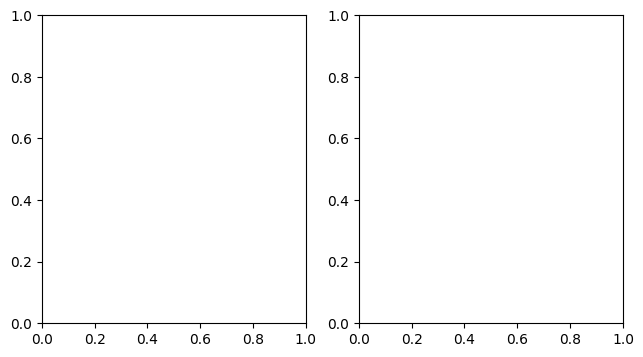

In [ ]:
#or alternatively
import torchvision

fig, axes = plt.subplots(1, 2, figsize=(1.5*5,2*2))

visited_labels = set()
train_loader_iter = iter(train_loader)

while len(visited_labels) < 2:
    (features,idx), labels = next(train_loader_iter)
    for i, label in enumerate(labels):
        if label not in visited_labels:
            ax = axes[len(visited_labels)]
            visited_labels.add(label)
            ax.imshow(features[i].permute(1, 2, 0), cmap='gray')
            ax.set_title('Label: {}'.format(label))
            print(idx[i])
plt.show()           

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
!pip install densenet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
from densenet_pytorch import DenseNet
model = DenseNet.from_name("densenet121")

In [8]:
import torch.optim as optim
import torchvision.models as models

model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
epochs = 50

train_losses = []
train_accs = []

test_losses = []
test_accs  = []

test_predictions = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    batch_corr = 0
    
    for batch_idx, ((X_train, idx), y_train) in enumerate(train_loader):

        y_train = list(y_train)

        for j in range(len(y_train)):
            if y_train[j] == 'real':
                y_train[j] = 0
            else:
                y_train[j] = 1

        y_train = torch.tensor(np.asarray(y_train))

        X_train, y_train = X_train.to(device), y_train.to(device)

        # y_pred = model(X_train.view(100, -1))
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
           
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            
            if batch_idx == 0:
                batch_accuracy = 0
            else:
                #batch accuracy
                batch_accuracy = trn_corr.item()*100 / (batch_idx * len(X_train))
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.6f}'.format(
                i, batch_idx * len(X_train), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), batch_accuracy))

    accuracy = trn_corr.item()*100 / (len(train_dataset))

    train_losses.append(loss)
    train_accs.append(accuracy)

    with torch.no_grad():
      
         for (X_test,idx), y_test in test_loader:
          
             y_test = list(y_test)

             for j in range(len(y_test)):
                 if y_test[j] == 'real':
                     y_test[j] = 0
                 else:
                     y_test[j] = 1

             y_test = torch.tensor(np.asarray(y_test))

             X_test, y_test = X_test.to(device), y_test.to(device)
            
             y_val = model(X_test)
            
             predicted = torch.max(y_val.data, 1)[1]
             tst_corr += (predicted == y_test).sum()

             if i == epochs - 1:
                 test_predictions.extend(predicted.cpu().numpy())

    test_accuracy = tst_corr.item()*100 / (len(test_dataset))

    val_loss = criterion(y_val,y_test)
    test_losses.append(val_loss)
    test_accs.append(test_accuracy)
    print( f'epoch: {i} training loss:{loss.item()} training accuracy:{accuracy} val loss:{val_loss.item()} val accuracy:{test_accuracy}')
    # print( f'epoch: {i} training loss:{loss.item()} training accuracy:{accuracy}')

Train Epoch: 0 [0/2400 (0%)]	Loss: 7.089717	Accuracy: 0.000000
Train Epoch: 0 [640/2400 (26%)]	Loss: 0.743995	Accuracy: 62.656250
Train Epoch: 0 [1280/2400 (53%)]	Loss: 0.637993	Accuracy: 63.203125
Train Epoch: 0 [1920/2400 (79%)]	Loss: 0.664951	Accuracy: 63.020833
epoch: 0 training loss:0.626931369304657 training accuracy:61.666666666666664 val loss:0.6784024238586426 val accuracy:51.111111111111114
Train Epoch: 1 [0/2400 (0%)]	Loss: 0.696870	Accuracy: 0.000000
Train Epoch: 1 [640/2400 (26%)]	Loss: 0.720463	Accuracy: 69.843750
Train Epoch: 1 [1280/2400 (53%)]	Loss: 0.552651	Accuracy: 67.265625
Train Epoch: 1 [1920/2400 (79%)]	Loss: 0.575453	Accuracy: 67.916667
epoch: 1 training loss:0.5889642834663391 training accuracy:66.41666666666667 val loss:0.7729671001434326 val accuracy:51.388888888888886
Train Epoch: 2 [0/2400 (0%)]	Loss: 0.588038	Accuracy: 0.000000
Train Epoch: 2 [640/2400 (26%)]	Loss: 0.605111	Accuracy: 72.968750
Train Epoch: 2 [1280/2400 (53%)]	Loss: 0.589260	Accuracy: 70.0

In [10]:
test_losses = []
test_accs  = []

tst_corr = 0

with torch.no_grad():
      
    for (X_test,idx), y_test in test_loader:
      
        y_test = list(y_test)

        for j in range(len(y_test)):
            if y_test[j] == 'real':
                y_test[j] = 0
            else:
                y_test[j] = 1

        y_test = torch.tensor(np.asarray(y_test))

        X_test, y_test = X_test.to(device), y_test.to(device)
        
        y_val = model(X_test)
        
        predicted = torch.max(y_val.data, 1)[1]
        tst_corr += (predicted == y_test).sum()

        test_predictions.extend(predicted.cpu().numpy())

test_accuracy = tst_corr.item()*100 / (len(test_dataset))

val_loss = criterion(y_val,y_test)
test_losses.append(val_loss)
test_accs.append(test_accuracy)
print( f'epoch: {i} training loss:{loss.item()} training accuracy:{accuracy} val loss:{val_loss.item()} val accuracy:{test_accuracy}')

epoch: 49 training loss:0.00037774653173983097 training accuracy:100.0 val loss:3.8162643909454346 val accuracy:51.388888888888886


In [ ]:
#save to new csv

test_predictions_df = pd.DataFrame(test_predictions, columns=['original_data'])

test_predictions_df.to_csv('/content/drive/MyDrive/Project/processed_data/densenet.csv', index=False)

In [11]:
# to existing csv

existing_df = pd.read_csv('/content/drive/MyDrive/Project/processed_data/densenet.csv')

assert len(test_predictions) == len(existing_df), "The number of predictions and the number of rows in the existing DataFrame must match."

#name to be changed
existing_df['densenet_hsv_50'] = test_predictions

existing_df.to_csv('/content/drive/MyDrive/Project/processed_data/densenet.csv', index=False)